In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('/content/drive/MyDrive/train.csv')
data = data.drop(['Customer ID', 'Name','Property ID', 'Expense Type 2','Income Stability'],axis=1)

In [4]:
data= data[data['Income (USD)']<10000]
data = data[data['Loan Sanction Amount (USD)']>=0]
data = data[data['Property Price']> 0]
data = data[data['Property Price'] < 600000]
data = data[data['Dependents'] < 6]

In [5]:
data['Type of Employment'].fillna('Other',inplace=True)
data['Dependents'].fillna(data['Dependents'].mode()[0],inplace=True)
data['Credit Score'].fillna(data['Credit Score'].mode()[0],inplace=True)
data['Has Active Credit Card'].fillna(data['Has Active Credit Card'].mode()[0],inplace=True)
data['Property Location'].fillna(data['Property Location'].mode()[0],inplace=True)
data['Gender'].fillna(data['Gender'].mode()[0],inplace=True)
data['Current Loan Expenses (USD)'].fillna(data['Current Loan Expenses (USD)'].median(),inplace=True)
data.drop(['Property Age'],axis=1,inplace=True)
data.head()

,Gender,Age,Income (USD),Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,F,56,1933.05,Working,Sales staff,Semi-Urban,72809.58,241.08,N,3.0,809.44,0,Active,4,Rural,1,119933.46,54607.18
1,M,32,4952.91,Working,Other,Semi-Urban,46837.47,495.81,N,1.0,780.40,0,Unpossessed,2,Rural,1,54791.00,37469.98
2,F,65,988.19,Pensioner,Other,Semi-Urban,45593.04,171.95,N,1.0,833.15,0,Unpossessed,2,Urban,0,72440.58,36474.43
5,F,60,1234.92,State servant,Secretaries,Rural,34434.72,181.48,N,2.0,684.12,1,Inactive,2,Rural,1,43146.82,22382.57
6,M,43,2361.56,Working,Laborers,Semi-Urban,152561.34,697.67,Y,2.0,637.29,0,Unpossessed,1,Semi-Urban,1,221050.80,0.00


In [6]:
data.isnull().sum()

Gender                         0
Age                            0
Income (USD)                   0
Profession                     0
Type of Employment             0
Location                       0
Loan Amount Request (USD)      0
Current Loan Expenses (USD)    0
Expense Type 1                 0
Dependents                     0
Credit Score                   0
No. of Defaults                0
Has Active Credit Card         0
Property Type                  0
Property Location              0
Co-Applicant                   0
Property Price                 0
Loan Sanction Amount (USD)     0
dtype: int64

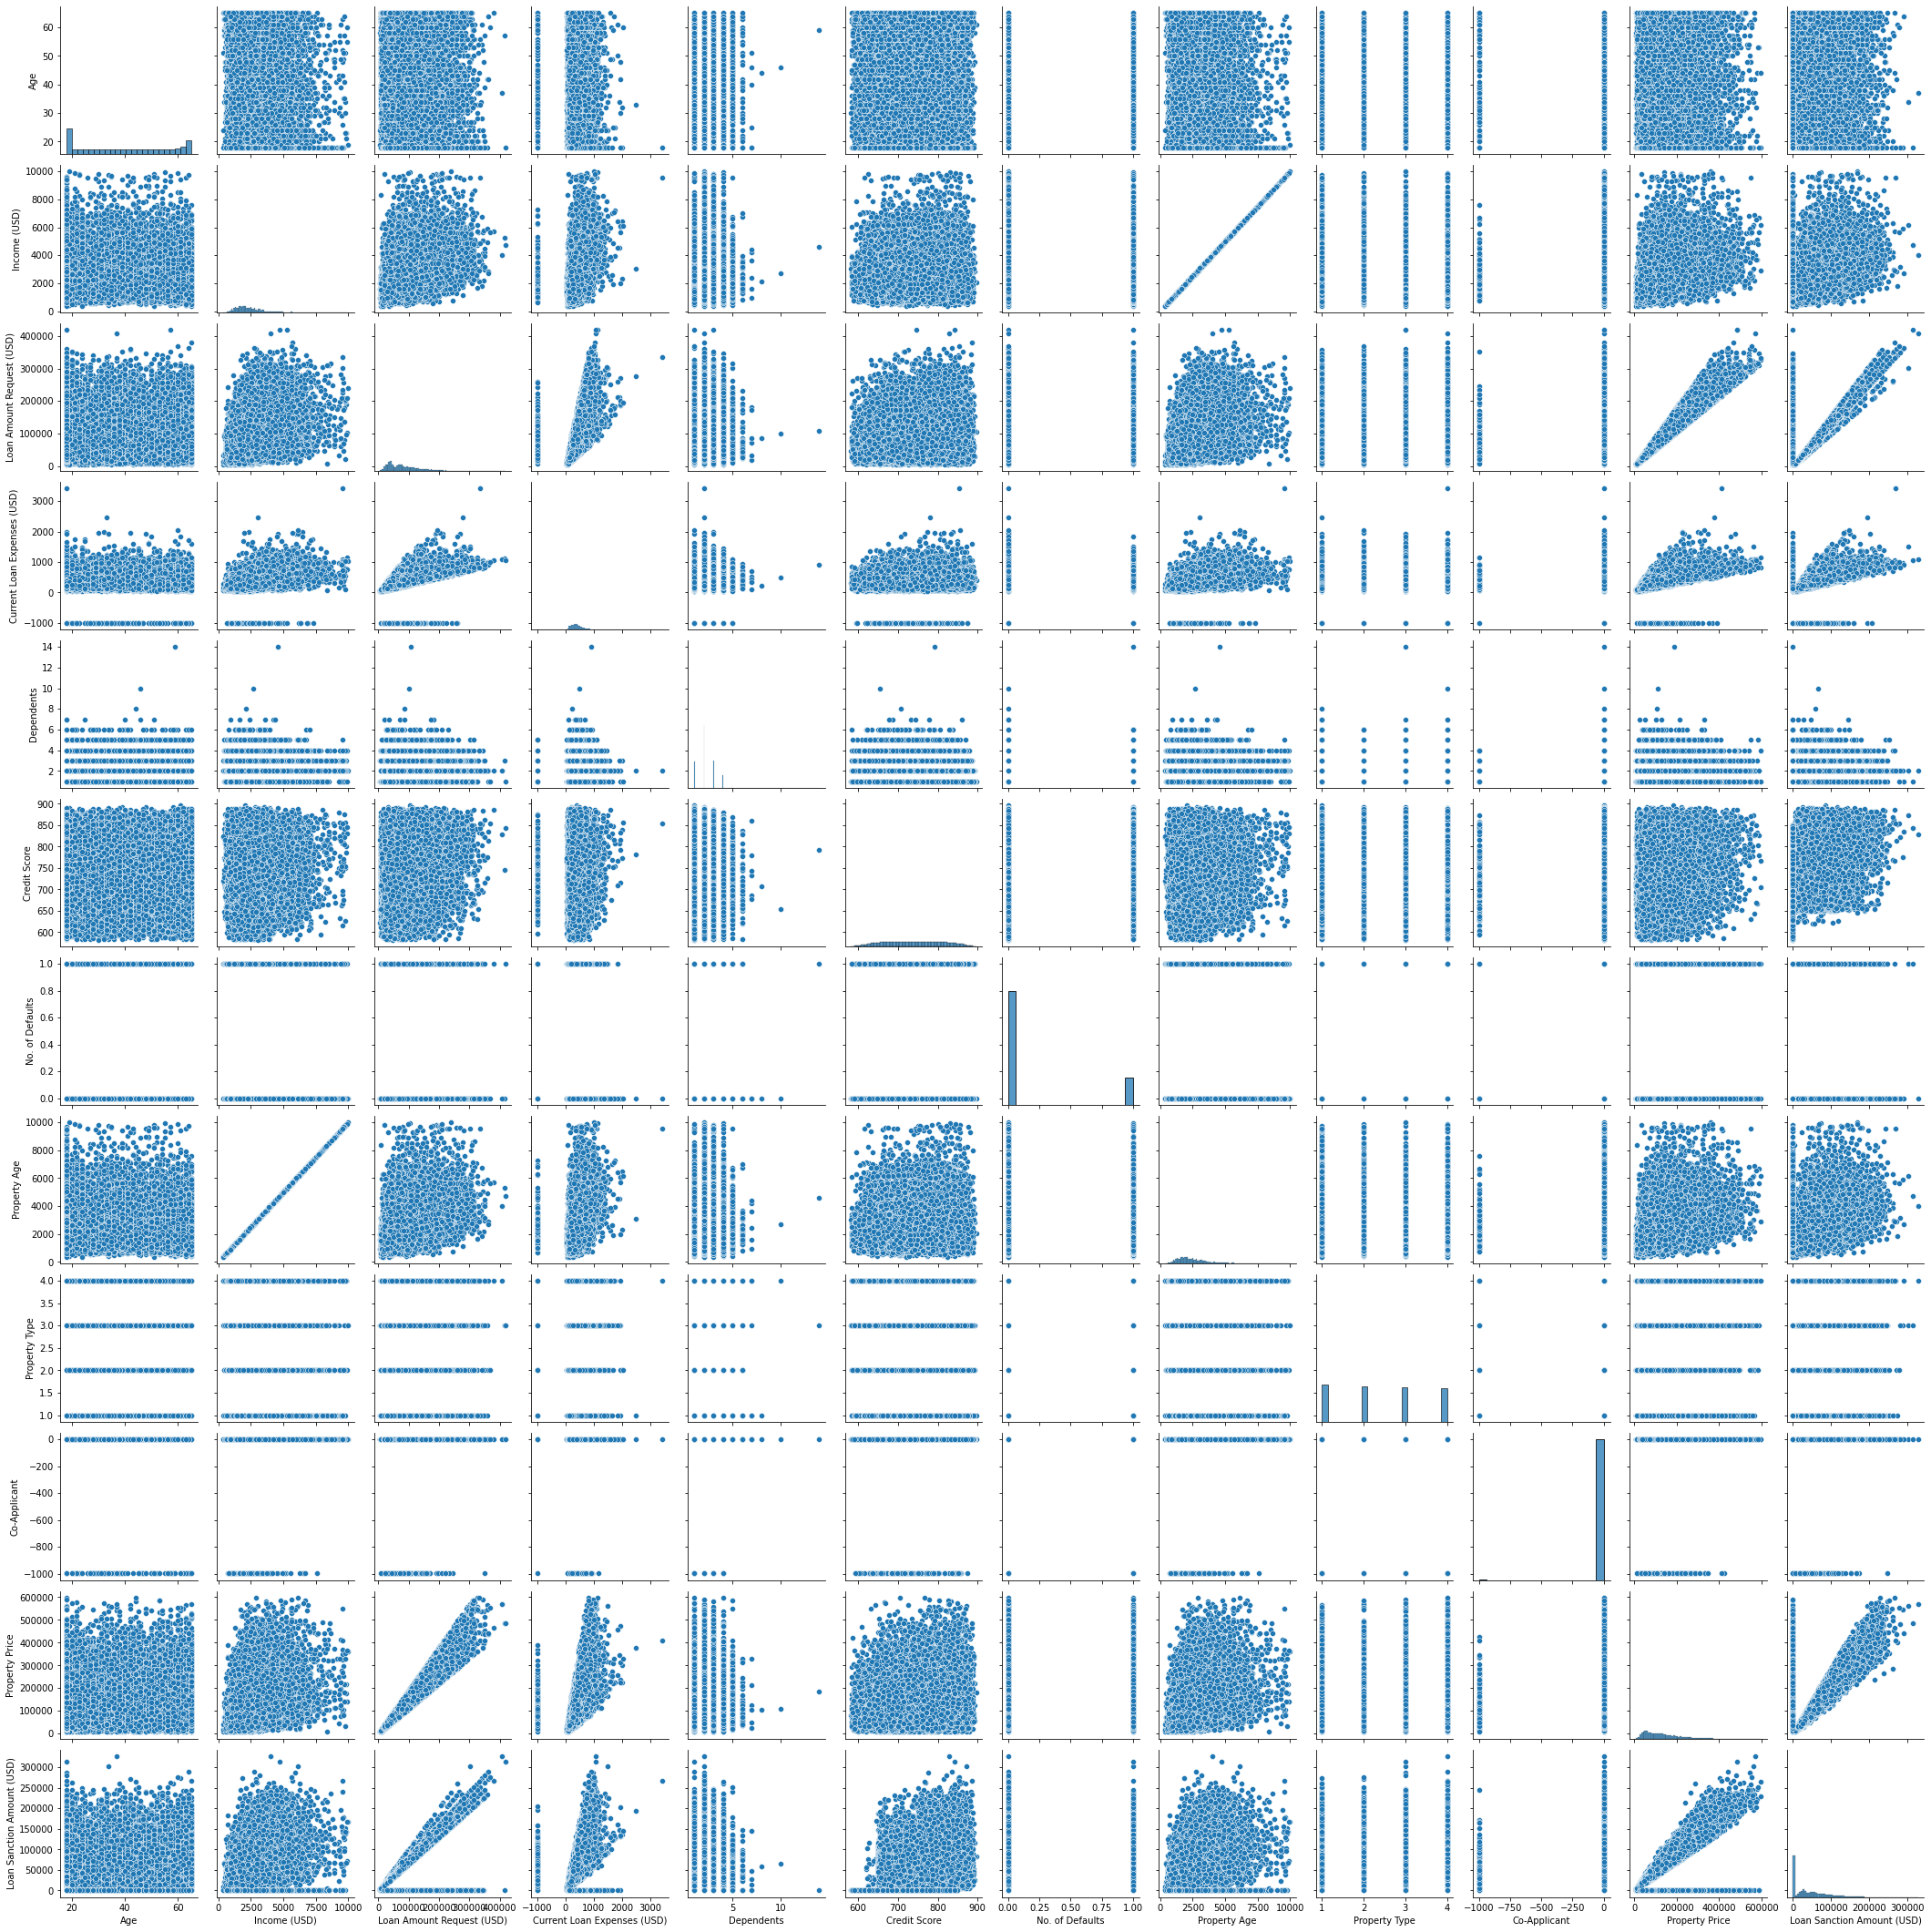

In [214]:
# sns.pairplot(data)

In [64]:

# sns.distplot(np.log1p(data['Loan Sanction Amount (USD)']))

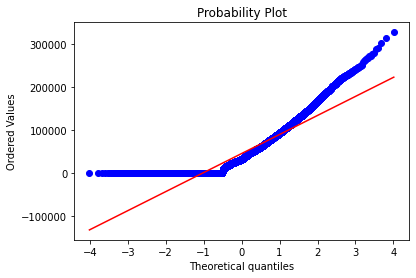

In [20]:
from scipy import stats
fig = plt.figure()
res = stats.probplot(data['Loan Sanction Amount (USD)'], plot=plt)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


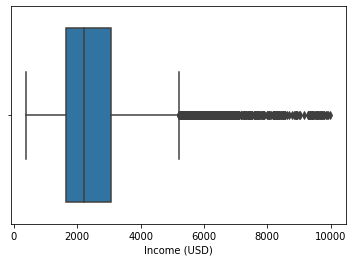

In [220]:
sns.boxplot(data['Income (USD)'])

In [67]:
# from scipy import stats
# z = np.abs(stats.zscore(data['Income (USD)']))
# data['Income (USD)'] = np.where(z < 3,data['Income (USD)'],data['Income (USD)'].median())

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


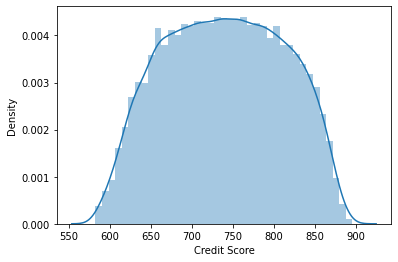

In [232]:
sns.distplot(data['Credit Score'])

In [7]:

import scipy.stats as ss

def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum() 
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

col_list = [data.columns[i] for i in np.where(data.dtypes == 'object')[0]]
kk=[]
for i in col_list:
  for j in col_list:
    confusion_matrix = pd.crosstab(data[i],data[j])
    kk.append((cramers_v(confusion_matrix.values),i,j))
for i in kk:
  if i[0] >0.5 and i[1] != i[2]:
    print(i)


In [8]:
data['newIncome'] = data.apply(lambda x : x['Income (USD)'] - x['Current Loan Expenses (USD)'],axis=1)
data.drop(['Income (USD)','Current Loan Expenses (USD)'],axis=1,inplace=True)

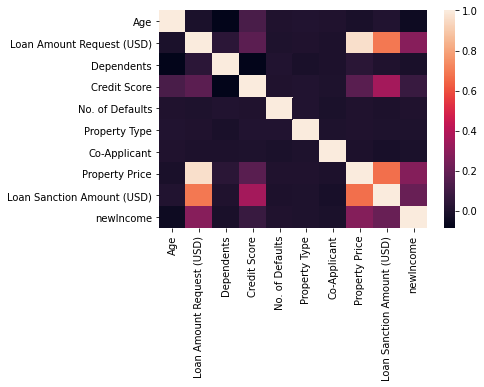

In [28]:
sns.heatmap(data.corr())

# CatBoost

In [9]:
df = data.copy()
X = df.drop(['Loan Sanction Amount (USD)','Property Price'],axis=1)
y = df['Loan Sanction Amount (USD)']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [10]:
!pip install catboost

In [11]:
cat_features = np.where(X.dtypes == 'object')[0]
from catboost import CatBoostRegressor,Pool
reg = CatBoostRegressor(loss_function='RMSE',verbose=0)
reg.fit(X_train,y_train,cat_features=cat_features, eval_set=(X_test,y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [14]:
pred = reg.predict(X_test)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print(mean_squared_error(pred,y_test),r2_score(pred,y_test))

427486686.9970483 0.7526383801900282


In [15]:
cat_features = np.where(X.dtypes == 'object')[0]
from catboost import CatBoostRegressor,Pool
reg = CatBoostRegressor(loss_function='RMSE',verbose=0)
reg.fit(X,y,cat_features=cat_features, eval_set=(X,y),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# LightGBM

In [16]:
df = data.copy()
obj_feat = list(df.loc[:, df.dtypes == 'object'].columns.values)
for feature in obj_feat:
    df[feature] = pd.Series(df[feature], dtype="category")

In [17]:

X = df.drop(['Loan Sanction Amount (USD)','Property Price'],axis=1)
y = df['Loan Sanction Amount (USD)']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [18]:
import lightgbm as lgb
hyper_params = {
    'task': 'train',
    'boosting_type': 'goss',
    'objective': 'regression',
    'metric': ['l2', 'auc'],
    'learning_rate': 0.01,
    "num_leaves": 128,  
    "max_bin": 512,
}
lgb_train = lgb.Dataset(X, y)
gbm = lgb.train(hyper_params, lgb_train, num_boost_round=100)

In [102]:
from sklearn.metrics import mean_squared_error
pred = gbm.predict(X_test)
print(mean_squared_error(pred,y_test),r2_score(pred,y_test))

723721073.5237693 -0.0380606832846937


# Test

In [19]:
data2 = pd.read_csv('/content/drive/MyDrive/test.csv')

data2.loc[data2['Co-Applicant']=='?','Co-Applicant'] = data2['Co-Applicant'].mode()[0]
data2['Co-Applicant'] = pd.Series(data2['Co-Applicant'], dtype="int")
data2 = data2.drop(['Name','Property ID', 'Expense Type 2','Income Stability'],axis=1)
data2['Gender'].fillna(data2['Gender'].mode()[0],inplace=True)
data2['Property Location'].fillna(data2['Property Location'].mode()[0],inplace=True)
data2['Credit Score'].fillna(data2['Credit Score'].mode()[0],inplace=True)
data2['Has Active Credit Card'].fillna(data2['Has Active Credit Card'].mode()[0],inplace=True)
data2['Type of Employment'].fillna('Other',inplace=True)
data2['Dependents'].fillna(data2['Dependents'].mode()[0],inplace=True)
data2['Income (USD)'].fillna(data2['Income (USD)'].median(),inplace=True)
data2['Current Loan Expenses (USD)'].fillna(data2['Current Loan Expenses (USD)'].median(),inplace=True)
data2['newIncome'] = data2.apply(lambda x : x['Income (USD)'] - x['Current Loan Expenses (USD)'],axis=1)
data2.drop(['Customer ID','Income (USD)','Current Loan Expenses (USD)','Property Price','Property Age'],axis=1,inplace=True)

In [133]:
# for col in data2.columns:
#   print(col,data2[col].apply(lambda x: str(x) in '?').sum())

In [20]:
obj_feat1 = list(data2.loc[:, data2.dtypes == 'object'].columns.values)
for feature in obj_feat1:
    data2[feature] = pd.Series(data2[feature], dtype="category")

In [21]:
pred1 = gbm.predict(data2)
pred2 = reg.predict(data2)
pred = (pred1 + pred2)/2

In [22]:
data3 = pd.read_csv('/content/drive/MyDrive/test.csv')

In [26]:
result = pd.DataFrame(data3['Customer ID'] ,columns=['Customer ID'])

result['Loan Sanction Amount (USD)'] = pred1
result.loc[result['Loan Sanction Amount (USD)']<=0,'Loan Sanction Amount (USD)'] = 0
result.head()

,Customer ID,Loan Sanction Amount (USD)
0,C-26247,72465.629236
1,C-35067,57447.963830
2,C-34590,17250.186534
3,C-16668,48522.245805
4,C-12196,56291.778434


In [28]:
result.to_csv('result4.csv',index=False)